Exercise 62

5.1 Deep GNN

This exercise is about setting up networks with several convolutional GNN layers. Also a head will be added to process the node representations before aggregation. The datafiles can be downloaded from Brightspace.

5.2 Datasets

The data is loaded like this:

In [ ]:
import numpy as np

data = np.load('dataset_for_exercise_62/nn_nnn_clusters_6.npz')



2


And the i'the datapoint is converted into a Torch Geometric graph by calling this function:

In [138]:
import torch
from torch_geometric.data import Data

def get_graph(index, data, cutoff=2.5, box_size=10):

    
    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)

    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)

get_graph(43,data
          )


Data(x=[6, 1], edge_index=[2, 10], y=-5.8997368812561035, pos=[6, 2])

b) Plot every 10th of the loaded graphs:

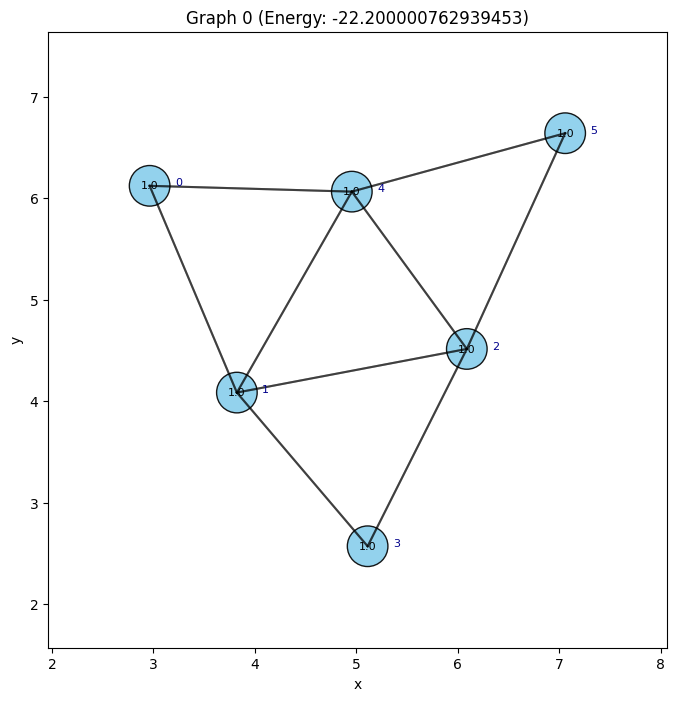

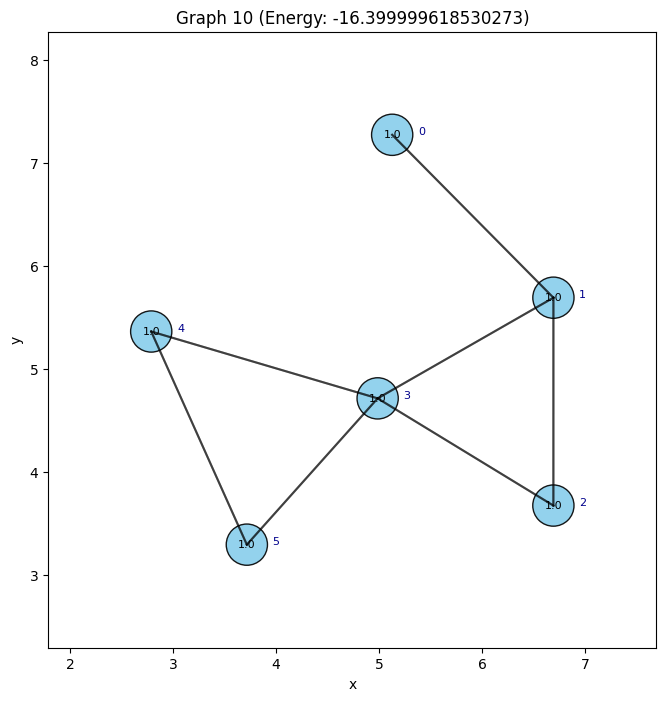

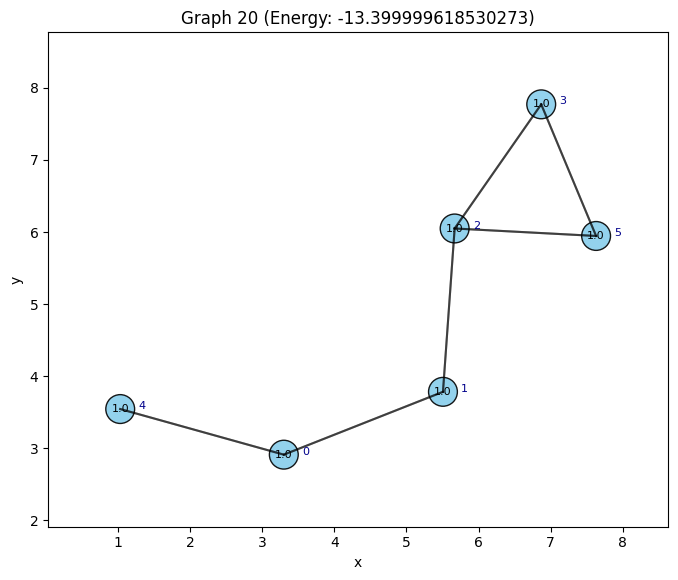

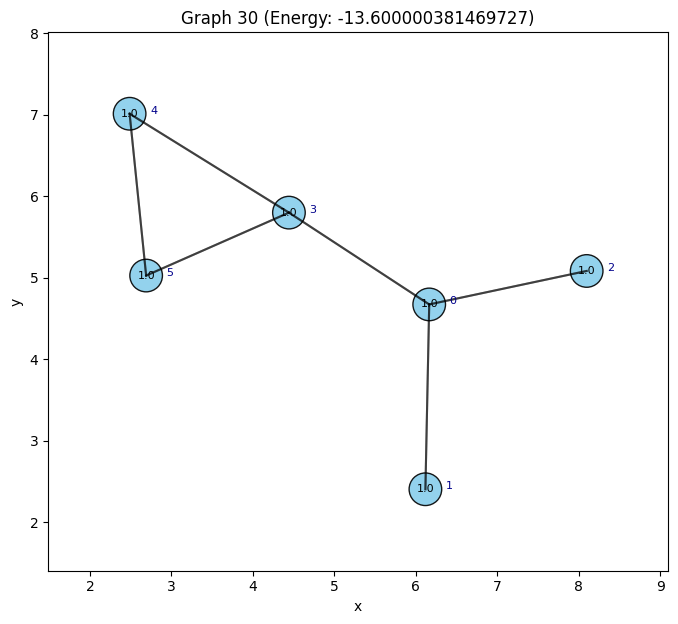

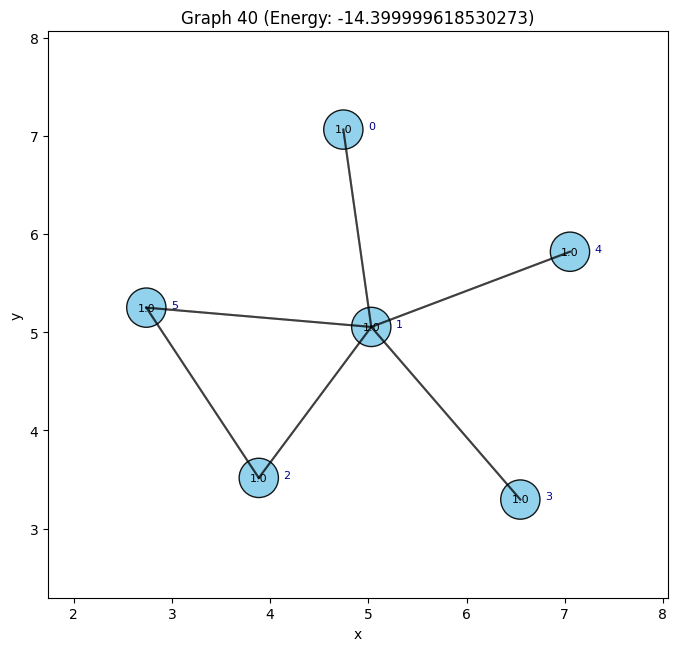

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def plot_graph(graph, title=None):
    """Plot the graph with nodes as circles, attribute values inside, and labels next to them."""
    pos = graph.pos.numpy()
    edge_index = graph.edge_index.numpy()
    attributes = graph.x.numpy().flatten()  # Node attributes
    label = graph.y.item()  # Graph label, assuming scalar

    plt.figure(figsize=(8, 8))
    
    # Plot edges
    for i, j in edge_index.T:
        plt.plot([pos[i, 0], pos[j, 0]], [pos[i, 1], pos[j, 1]], 'k-', alpha=0.5)

    # Plot nodes as circles
    for i, (x, y) in enumerate(pos):
        circle = plt.Circle((x, y), 0.2, color='skyblue', ec='black', alpha=0.9)
        plt.gca().add_patch(circle)
        plt.text(x, y, f"{attributes[i]:.1f}", fontsize=8, ha='center', va='center', color='black')  # Attribute inside

        # Label next to the circle
        plt.text(x + 0.25, y, f"{i}", fontsize=8, color='darkblue')

    # Set axis limits
    plt.xlim(pos[:, 0].min() - 1, pos[:, 0].max() + 1)
    plt.ylim(pos[:, 1].min() - 1, pos[:, 1].max() + 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.title(f"{title} (Energy: {label})" if title else f"Graph (Label: {label})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Example loop for plotting every 10th graph
for i in range(0, len(data['positions']), 10):
    graph = get_graph(i,data)  # Generate the graph
    plot_graph(graph, title=f"Graph {i}")


5.3 Fit with one message

c) Set up a model with a single Convolutional GNN layer with ψ and ϕ having one neuron each. Let the model aggregate the node values to produce one number per graph. 

In [74]:
import torch
from torch.nn import Linear, SiLU
from torch_geometric.nn import MessagePassing

class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, d_message=None, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = Linear(d_in, d_message)
        self.phi = Linear(d_in + d_message, d_out)

    def forward(self, x, edge_index):
        aggregated_messages = self.propagate(edge_index, x=x)
        x = self.phi(torch.cat([x, aggregated_messages], dim=-1))
        return x

    def message(self, x_j):
        return self.psi(x_j)


Sending one message

In [75]:
import torch
from torch_scatter import scatter
import torch.nn.functional as F

class SumAggregation:
    def __call__(self, x, batch):
        return scatter(x, batch, dim=0, reduce="sum")

In [76]:
class OneMessagePassingLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mp1 = PhiPsiGNN(1,1,1)
        self.aggr = SumAggregation()

    def forward(self,graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.mp1(graph.x, graph.edge_index)
        return x

    def local_energies(self, graph):
        x = self.representation(graph)
        return x.flatten()
    

Fit the model so that it reproduces the y-values on the graph as good as possible. Construct the parity plot:

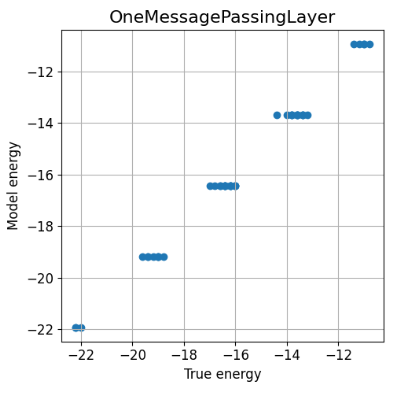

Training OneMessageLayer

Epoch 1/1000, Loss: 2069.2723
Epoch 2/1000, Loss: 1993.4856
Epoch 3/1000, Loss: 1936.2791
Epoch 4/1000, Loss: 1823.7902
Epoch 5/1000, Loss: 1768.8672
Epoch 6/1000, Loss: 1681.6757
Epoch 7/1000, Loss: 1622.0031
Epoch 8/1000, Loss: 1524.8932
Epoch 9/1000, Loss: 1463.2368
Epoch 10/1000, Loss: 1387.6627
Epoch 11/1000, Loss: 1315.8318
Epoch 12/1000, Loss: 1244.6729
Epoch 13/1000, Loss: 1172.1430
Epoch 14/1000, Loss: 1123.9716
Epoch 15/1000, Loss: 1037.2566
Epoch 16/1000, Loss: 976.4714
Epoch 17/1000, Loss: 914.5592
Epoch 18/1000, Loss: 857.8234
Epoch 19/1000, Loss: 803.0691
Epoch 20/1000, Loss: 738.5415
Epoch 21/1000, Loss: 698.3189
Epoch 22/1000, Loss: 643.3831
Epoch 23/1000, Loss: 591.8116
Epoch 24/1000, Loss: 545.4943
Epoch 25/1000, Loss: 498.1876
Epoch 26/1000, Loss: 459.0979
Epoch 27/1000, Loss: 414.0091
Epoch 28/1000, Loss: 376.4908
Epoch 29/1000, Loss: 341.8816
Epoch 30/1000, Loss: 318.4366
Epoch 31/1000, Loss: 285.4080
Epoch 32/1000, Loss: 254.1437
Epoch 33/1000, Loss: 228.9080
Epoc

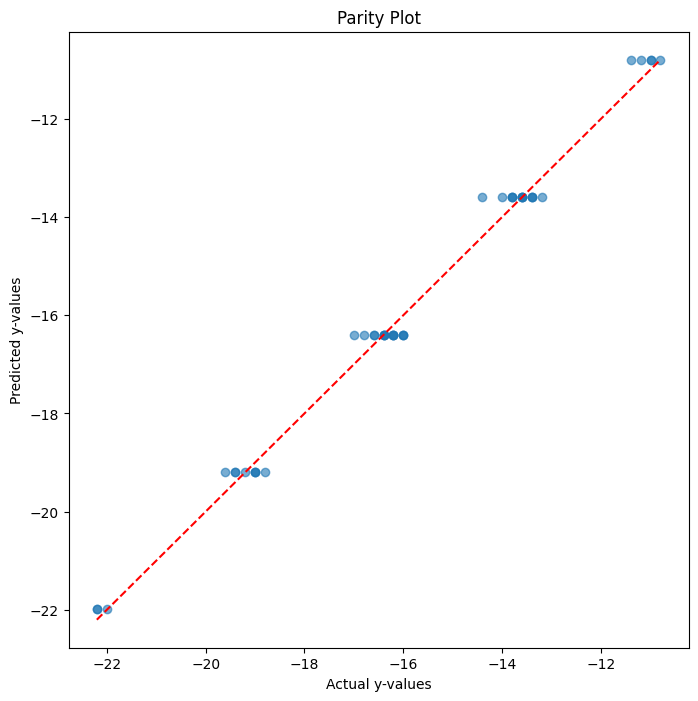

In [ ]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from torch_geometric.nn.aggr import SumAggregation

# Create Dataset
graphs = [get_graph(i,data) for i in range(len(data['positions']))]

graphs = [get_graph(i,data) for i in range(len(data['positions']))]
assert len(graphs) == 44, f"Expected 44 graphs, found {len(graphs)}."

train_graphs = graphs[:int(0.8 * len(graphs))]  # First 80%
test_graphs = graphs[int(0.8 * len(graphs)):]  # Remaining 20%

train_loader = DataLoader(train_graphs, batch_size=4, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=4, shuffle=False)

# Model, Loss, and Optimizer
model = OneMessagePassingLayer()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1000
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for graph in train_loader:
        optimizer.zero_grad()
        pred = model(graph)
        loss = loss_fn(pred, graph.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


# Evaluate and Collect Predictions for All Graphs
model.eval()
actual = []
predicted = []
with torch.no_grad():
    for loader in [train_loader, test_loader]:  # Process both train and test loaders
        for batch in loader:
            pred = model(batch)
            actual.extend(batch.y.cpu().numpy())
            predicted.extend(pred.cpu().numpy())

print(f"Collected actual energies: {len(actual)}")  # Should be 44


# Parity Plot
plt.figure(figsize=(8, 8))
plt.scatter(actual, predicted, alpha=0.6)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
plt.xlabel('Actual y-values')
plt.ylabel('Predicted y-values')
plt.title('Parity Plot')
plt.show()


d) Plot the local representation on each node right before the aggregation to a global value takes place:

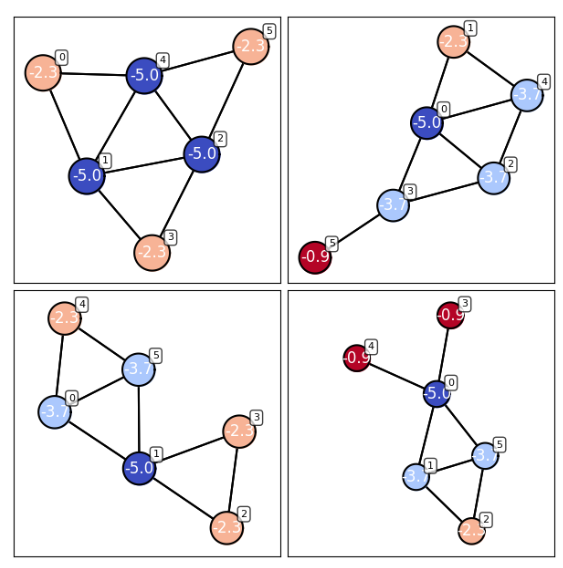

Notice how e.g. the dark blue nodes all have the attribute −5.

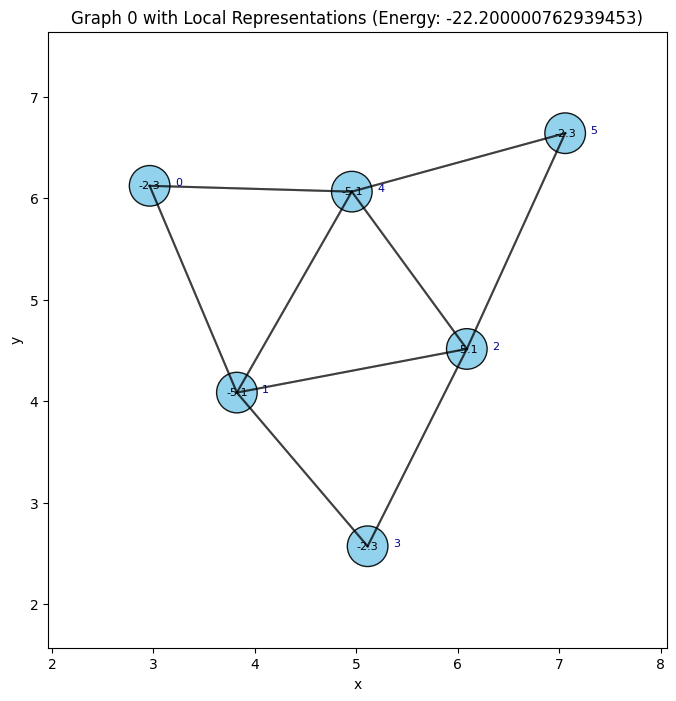

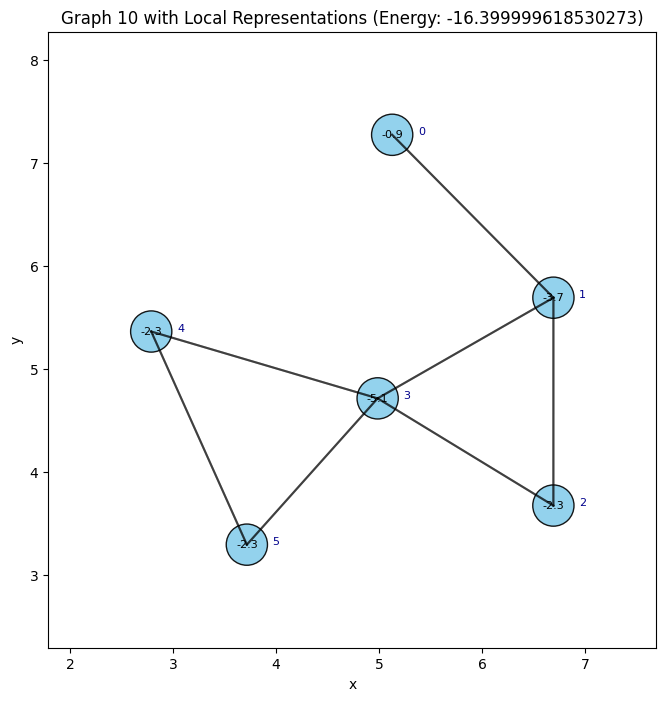

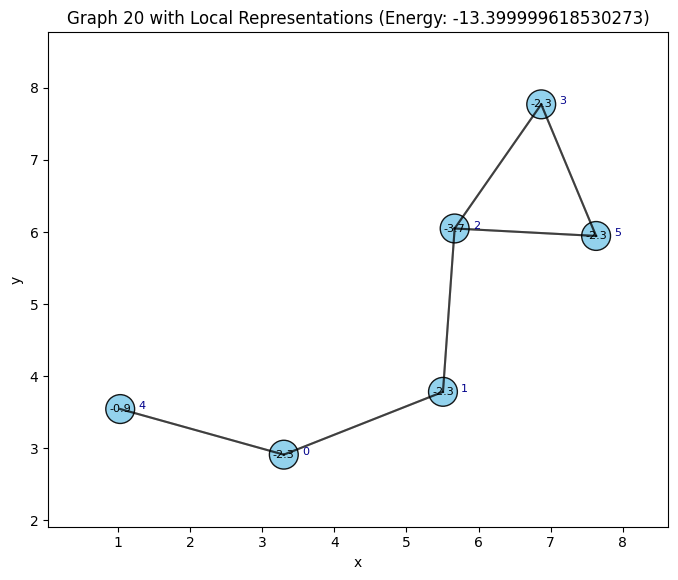

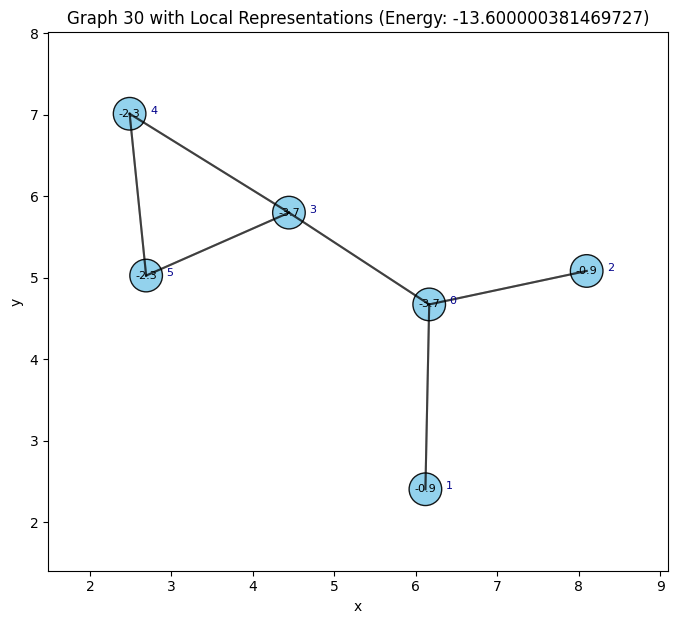

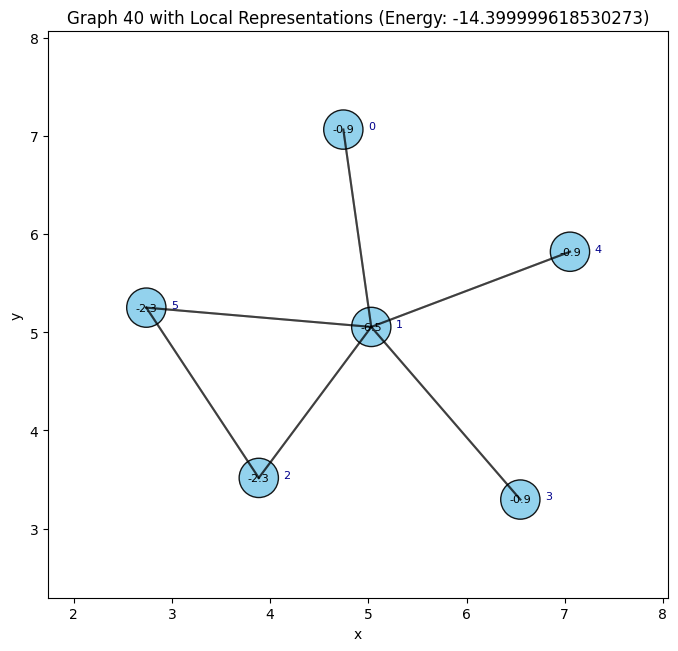

In [88]:
def get_graph_with_representations(index, model, cutoff=2.5, box_size=10):
    """Generate a graph and update node attributes with local representations."""
    # Create the graph
    graph = get_graph(index, cutoff, box_size)
    
    # Get the local node representations from the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        graph.x = model.representation(graph)  # Replace node attributes (x) with local representations
    
    return graph

# Example of plotting graphs with updated node representations
for i in range(0, len(data['positions']), 10):
    graph = get_graph_with_representations(i, model)  # Generate graph with updated attributes
    plot_graph(graph, title=f"Graph {i} with Local Representations")

5.4 Fit with two messages

e) Repeat d) and e) but have two CGNN layers.

In [89]:
class TwoMessagePassingLayer(torch.nn.Module):
    def __init__(self, mes1=1, hid1=1,mes2=1):
        super().__init__()
        self.mp1 = PhiPsiGNN(1,mes1, hid1)
        self.mp2 = PhiPsiGNN(hid1, mes2, 1)
        self.aggr = SumAggregation()

    def forward(self,graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.mp1(graph.x, graph.edge_index)
        x = self.mp2(x, graph.edge_index)
        return x

    def local_energies(self, graph):
        x = self.representation(graph)
        return x.flatten()
    

Training TwoMessageLayer

/home/jacob/comphy/Comphy/myenv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/1000, Loss: 4725.3503
Epoch 2/1000, Loss: 4574.3005
Epoch 3/1000, Loss: 4424.9771
Epoch 4/1000, Loss: 4296.4066
Epoch 5/1000, Loss: 4206.5267
Epoch 6/1000, Loss: 4110.8451
Epoch 7/1000, Loss: 4015.5312
Epoch 8/1000, Loss: 3930.6163
Epoch 9/1000, Loss: 3821.1720
Epoch 10/1000, Loss: 3744.4124
Epoch 11/1000, Loss: 3703.7129
Epoch 12/1000, Loss: 3611.7944
Epoch 13/1000, Loss: 3537.6293
Epoch 14/1000, Loss: 3490.8185
Epoch 15/1000, Loss: 3408.1130
Epoch 16/1000, Loss: 3376.6964
Epoch 17/1000, Loss: 3304.7055
Epoch 18/1000, Loss: 3271.5884
Epoch 19/1000, Loss: 3180.8816
Epoch 20/1000, Loss: 3106.3371
Epoch 21/1000, Loss: 3046.3886
Epoch 22/1000, Loss: 2980.3925
Epoch 23/1000, Loss: 2871.7431
Epoch 24/1000, Loss: 2815.5171
Epoch 25/1000, Loss: 2731.0296
Epoch 26/1000, Loss: 2630.5803
Epoch 27/1000, Loss: 2516.7070
Epoch 28/1000, Loss: 2399.1564
Epoch 29/1000, Loss: 2231.5627
Epoch 30/1000, Loss: 2098.6622
Epoch 31/1000, Loss: 1910.2434
Epoch 32/1000, Loss: 1739.7934
Epoch 33/1000, Lo

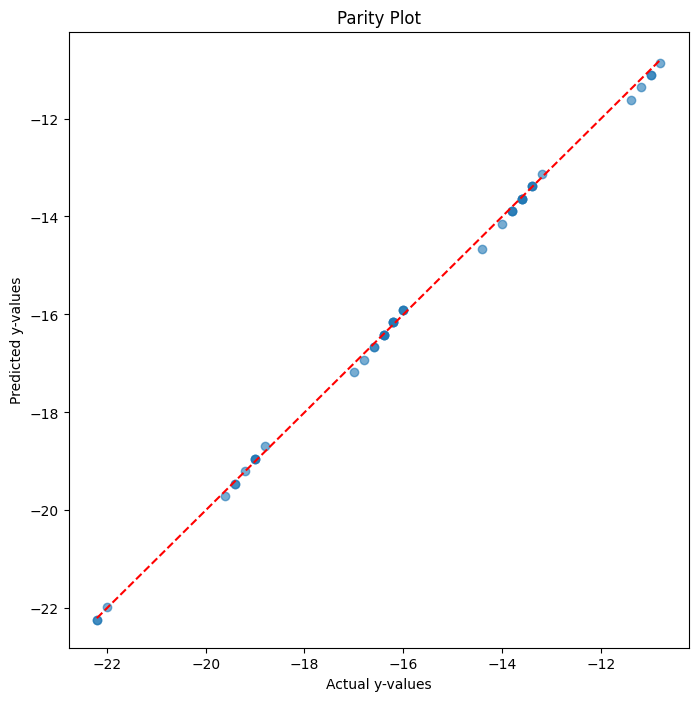

In [ ]:
# Create Dataset
graphs = [get_graph(i,data) for i in range(len(data['positions']))]

graphs = [get_graph(i,data) for i in range(len(data['positions']))]
assert len(graphs) == 44, f"Expected 44 graphs, found {len(graphs)}."

train_graphs = graphs[:int(0.8 * len(graphs))]  # First 80%
test_graphs = graphs[int(0.8 * len(graphs)):]  # Remaining 20%

train_loader = DataLoader(train_graphs, batch_size=4, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=4, shuffle=False)

# Model, Loss, and Optimizer
model = TwoMessagePassingLayer()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1000
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for graph in train_loader:
        optimizer.zero_grad()
        pred = model(graph)
        loss = loss_fn(pred, graph.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


# Evaluate and Collect Predictions for All Graphs
model.eval()
actual = []
predicted = []
with torch.no_grad():
    for loader in [train_loader, test_loader]:  # Process both train and test loaders
        for batch in loader:
            pred = model(batch)
            actual.extend(batch.y.cpu().numpy())
            predicted.extend(pred.cpu().numpy())

print(f"Collected actual energies: {len(actual)}")  # Should be 44


# Parity Plot
plt.figure(figsize=(8, 8))
plt.scatter(actual, predicted, alpha=0.6)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
plt.xlabel('Actual y-values')
plt.ylabel('Predicted y-values')
plt.title('Parity Plot')
plt.show()


Plot graphs

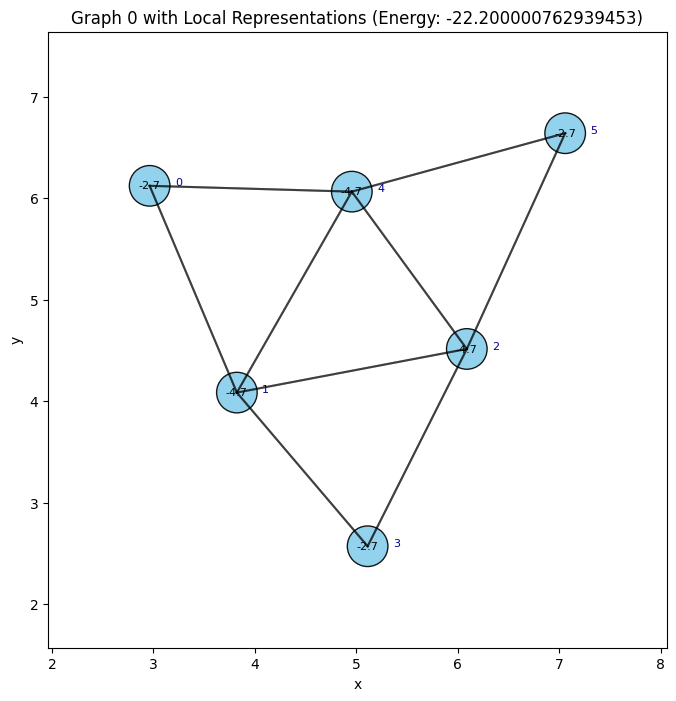

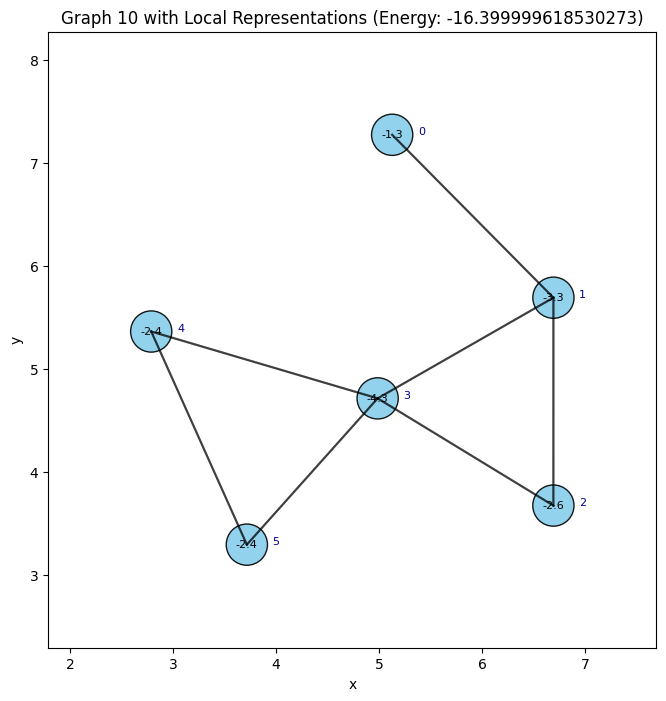

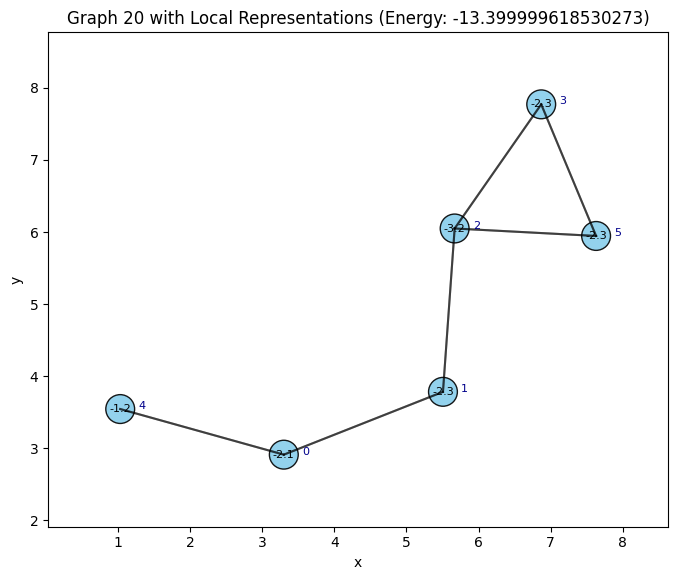

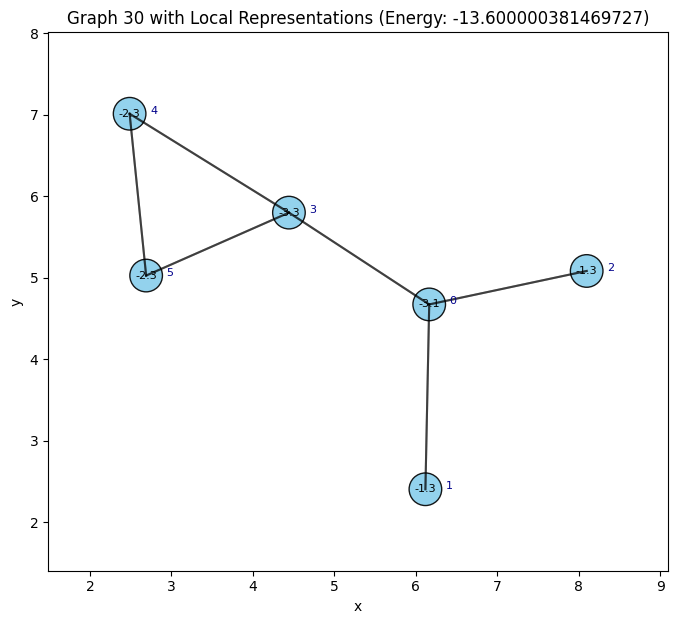

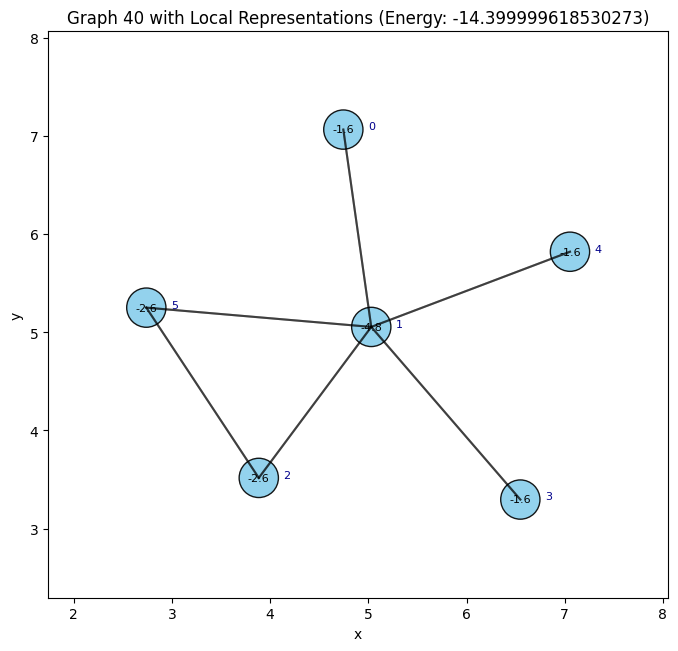

In [91]:
for i in range(0, len(data['positions']), 10):
    graph = get_graph_with_representations(i, model)  # Generate graph with updated attributes
    plot_graph(graph, title=f"Graph {i} with Local Representations")

Notice how e.g. the dark blue nodes now have attributes from −4.4 and not just −5.

f) Explain how you suspect the graph labels were made in the first place. What would the formula be for the graph labels in terms of nearest neighbors and next-nearest neighbors? Remember self-loops.

We add E = 0.9 Nearest Neighbour Value + 0.1 Next Nearest Neigbour Value!


5.5 Tight-binding energy labels

g) Now load the data with tight-binding energy labels and

Using MODIFIED = False you will get real tight-binding energy labels, while using MODIFIED = True you will get some slightly modified labels that are guaranteed to be learnable by Convolutional GNNs. We keep MODIFIED = True here.

h) Keep graphs with indices: [23, 36, 21, 19, 9, 39, 42, 3, 0] for test purposes and plot them.

Number of test graphs: 9


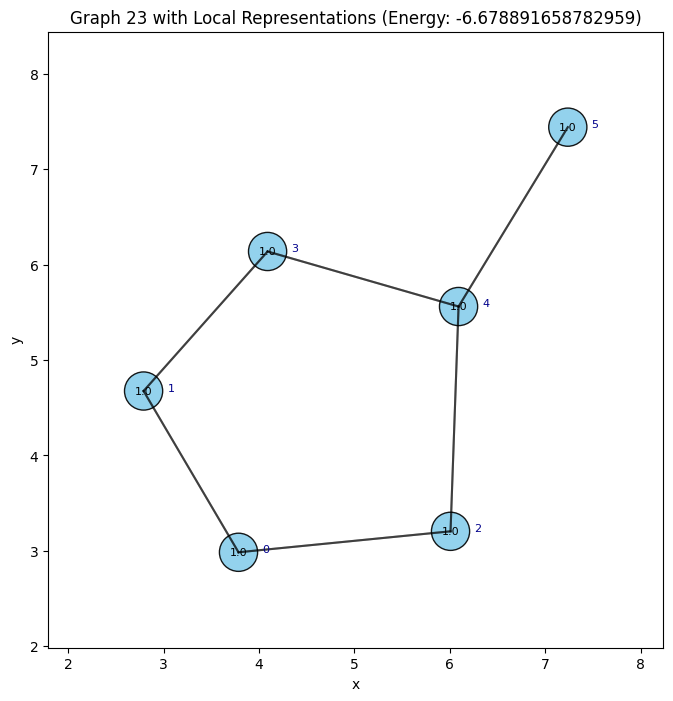

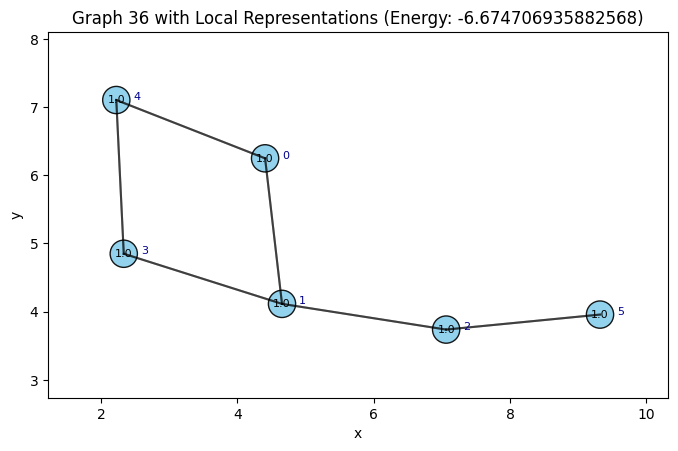

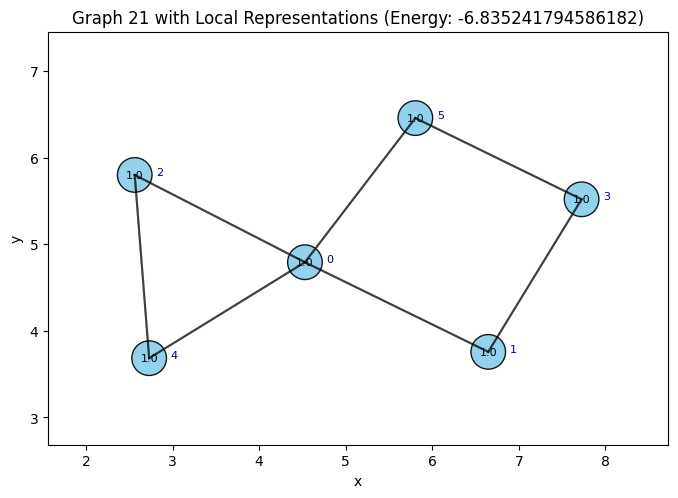

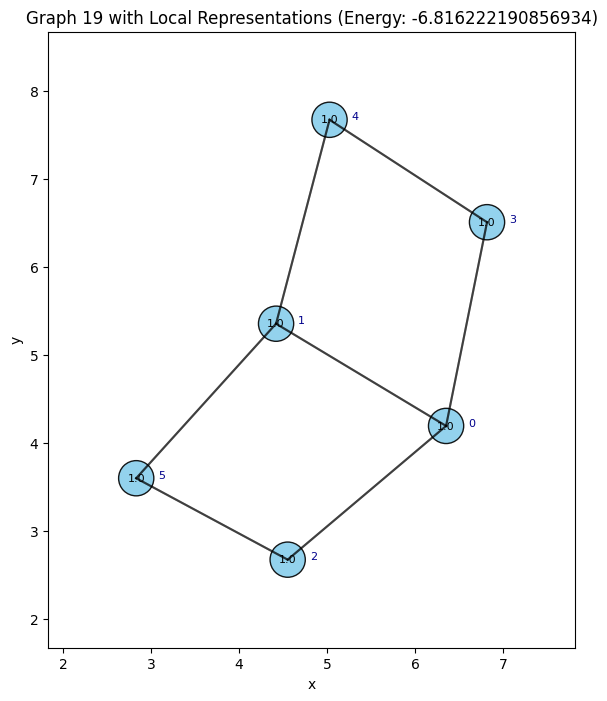

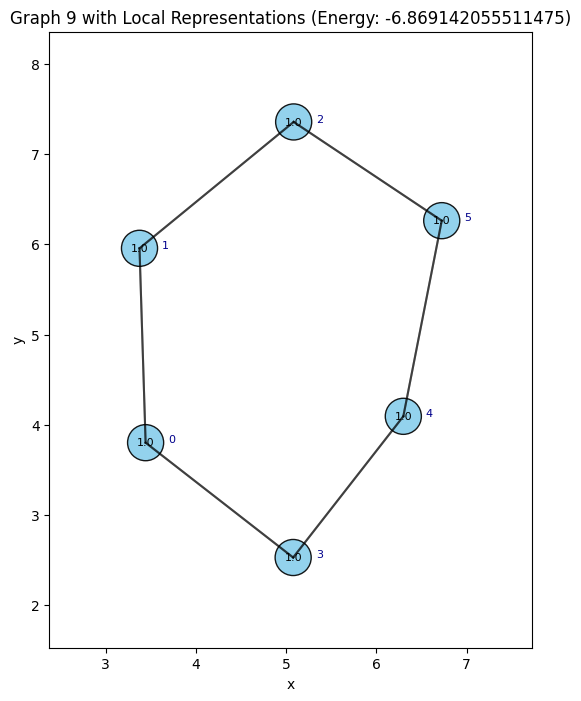

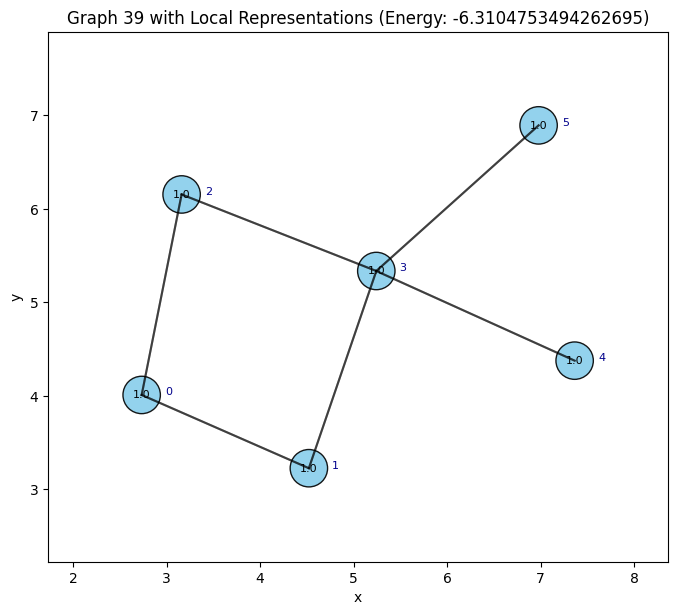

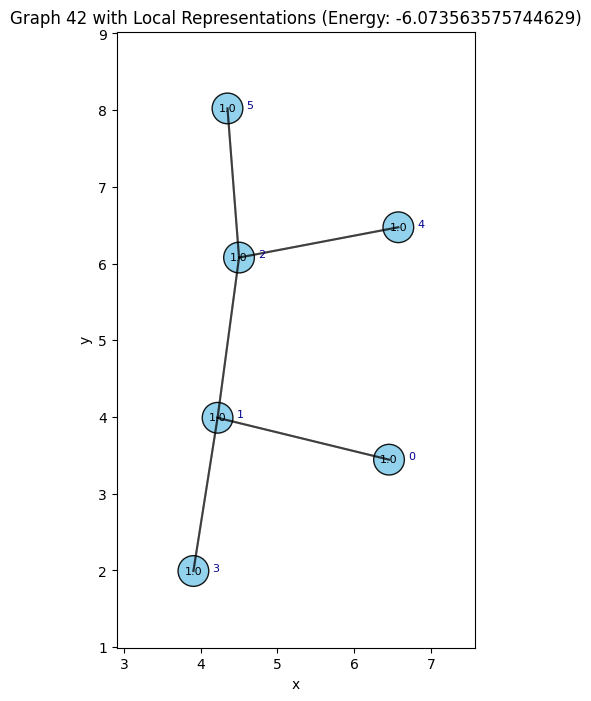

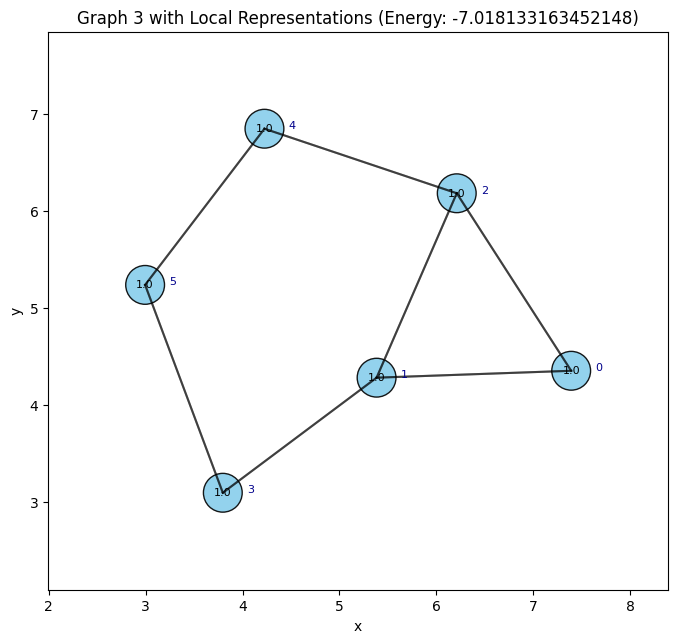

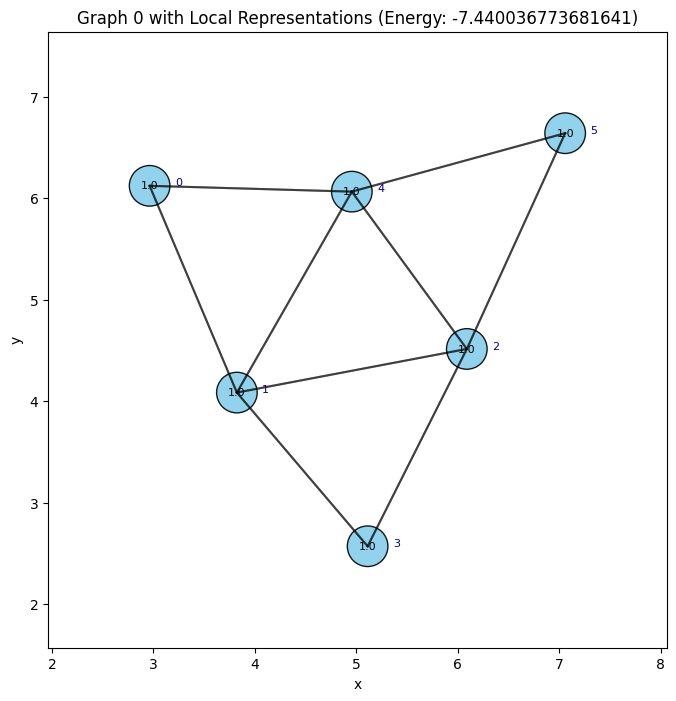

In [142]:
MODIFIED = True
if MODIFIED:
    TB_data = np.load('dataset_for_exercise_62/modified_tb_clusters_6.npz')
else:
    TB_data = np.load('dataset_for_exercise_62/tight_binding_clusters_6.npz')

# These are the indices of graphs you want to extract from TB_data
index_test_graphs = [23, 36, 21, 19, 9, 39, 42, 3, 0]

# Extract the test graphs by their indices
test_graphs = [get_graph(idx, TB_data) for idx in index_test_graphs]

# Check the number of extracted graphs
print(f"Number of test graphs: {len(test_graphs)}")  # Should print 9

# Plot the test graphs
for i, graph in enumerate(test_graphs):
    plot_graph(graph, title=f"Graph {index_test_graphs[i]} with Local Representations")


Construct a Torch Geometric DataLoader based on the other graphs. 

In [152]:
from torch_geometric.data import DataLoader
import numpy as np

def construct_dataloaders(index_test_graphs, batch_size=4, modified=True):
    if modified:
        TB_data = np.load('dataset_for_exercise_62/modified_tb_clusters_6.npz')
    else:
        TB_data = np.load('dataset_for_exercise_62/tight_binding_clusters_6.npz')

    num_graphs = len(TB_data['positions'])
    remaining_indices = [i for i in range(num_graphs) if i not in index_test_graphs]
    remaining_graphs = [get_graph(idx, TB_data) for idx in remaining_indices]
    test_graphs = [get_graph(idx, TB_data) for idx in index_test_graphs]
    train_loader = DataLoader(remaining_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)


    return train_loader, test_loader

# Indices for test graphs
index_test_graphs = [23, 36, 21, 19, 9, 39, 42, 3, 0]

# Call the method for the modified dataset
train_loader, test_loader = construct_dataloaders(index_test_graphs, batch_size=4, modified=True)

# Call the method for the unmodified dataset
train_loader, test_loader = construct_dataloaders(index_test_graphs, batch_size=4, modified=False)



5.6 Two CGNN layers

i) Try fit the tight-binding labels with a model containing two Convolutional GNN layers.

Epoch 100/1000, Loss: 0.2730
Epoch 200/1000, Loss: 0.2628
Epoch 300/1000, Loss: 0.2696
Epoch 400/1000, Loss: 0.2557
Epoch 500/1000, Loss: 0.2492
Epoch 600/1000, Loss: 0.2547
Epoch 700/1000, Loss: 0.2258
Epoch 800/1000, Loss: 0.2340
Epoch 900/1000, Loss: 0.2244
Epoch 1000/1000, Loss: 0.2127
Epoch 100/1000, Loss: 0.2804
Epoch 200/1000, Loss: 0.2585
Epoch 300/1000, Loss: 0.2829
Epoch 400/1000, Loss: 0.2634
Epoch 500/1000, Loss: 0.2694
Epoch 600/1000, Loss: 0.2653
Epoch 700/1000, Loss: 0.2805
Epoch 800/1000, Loss: 0.2499
Epoch 900/1000, Loss: 0.2676
Epoch 1000/1000, Loss: 0.2585


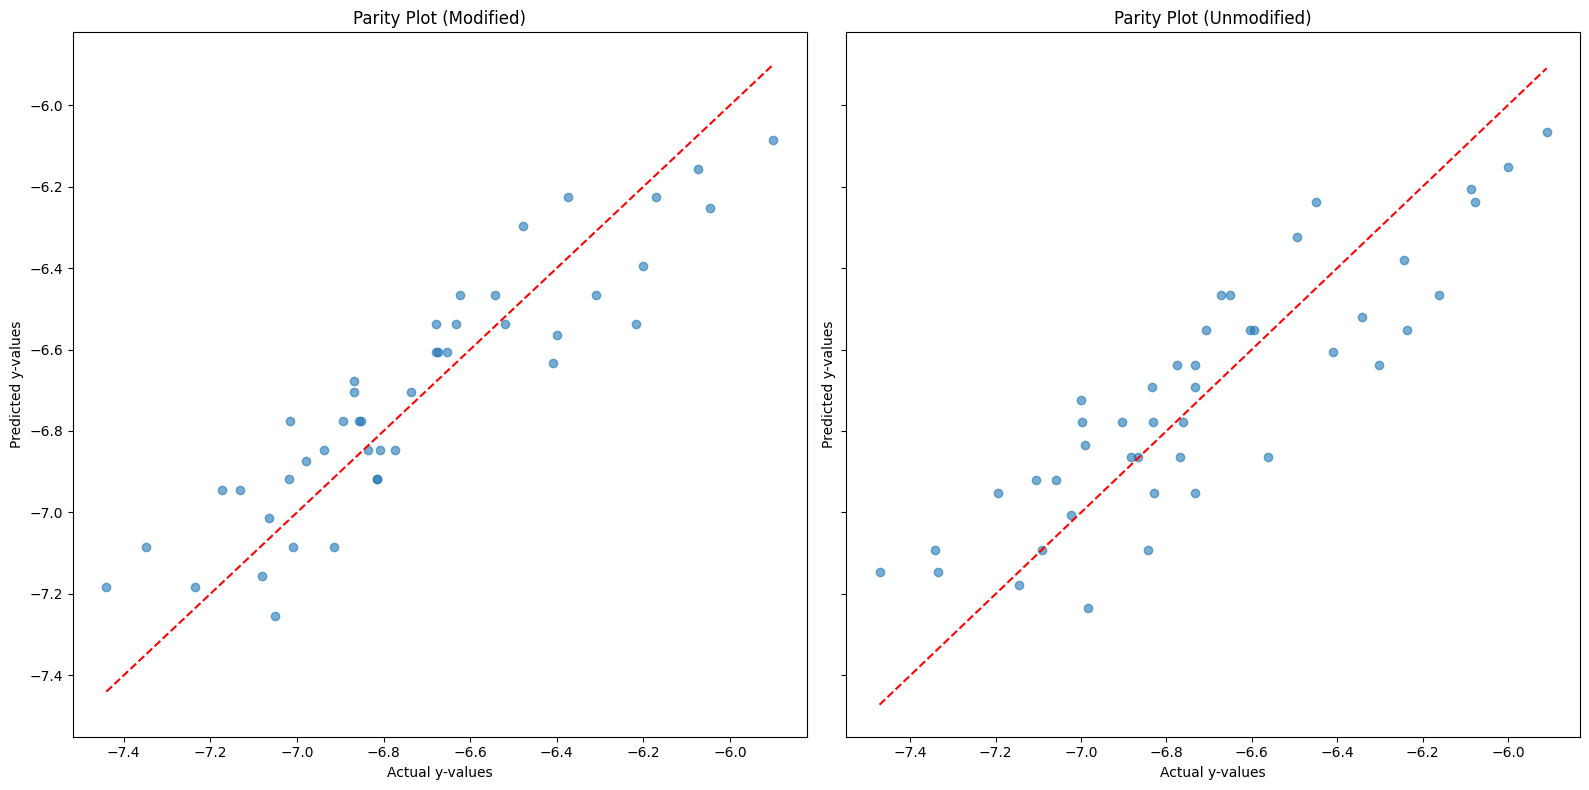

In [ ]:
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torch.optim import Adam

def train_and_evaluate(model, train_loader, test_loader, epochs=1000, lr=1e-3):
    """Train the model and evaluate it on train and test sets."""
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    # Training Loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for graph in train_loader:
            optimizer.zero_grad()
            pred = model(graph)
            loss = loss_fn(pred, graph.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    # Evaluate and collect predictions
    model.eval()
    actual, predicted = [], []
    with torch.no_grad():
        for loader in [train_loader, test_loader]:
            for batch in loader:
                pred = model(batch)
                actual.extend(batch.y.cpu().numpy())
                predicted.extend(pred.cpu().numpy())
    
    return actual, predicted

def plot_parity(actual, predicted, title, ax):
    """Plot a parity plot."""
    ax.scatter(actual, predicted, alpha=0.6)
    ax.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    ax.set_xlabel('Actual y-values')
    ax.set_ylabel('Predicted y-values')
    ax.set_title(title)

# Prepare model and DataLoaders
model = TwoMessagePassingLayer()

# Run for both datasets (modified and unmodified)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
datasets = {"Modified": True, "Unmodified": False}
for i, (label, modified) in enumerate(datasets.items()):
    train_loader, test_loader = construct_dataloaders(index_test_graphs, batch_size=4, modified=modified)
    actual, predicted = train_and_evaluate(model, train_loader, test_loader, epochs=1000, lr=1e-3)
    plot_parity(actual, predicted, f"Parity Plot ({label})", axes[i])

plt.tight_layout()
plt.show()


5.7 Four CGNN layers

j) Try to fit the TB labels with a model containing four Convolutional GNN layers.

In [159]:
class FourMessagePassingLayer(torch.nn.Module):
    def __init__(self, mes1=1, hid1=1, mes2=1, hid2=1, mes3=1, hid3=1, mes4=1):
        super().__init__()
        self.mp1 = PhiPsiGNN(1, mes1, hid1)       # First layer
        self.mp2 = PhiPsiGNN(hid1, mes2, hid2)    # Second layer
        self.mp3 = PhiPsiGNN(hid2, mes3, hid3)    # Third layer
        self.mp4 = PhiPsiGNN(hid3, mes4, 1)       # Fourth layer
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)  # Aggregate to graph-level representation
        return x.flatten()
    
    def representation(self, graph):
        # Pass through all 4 layers
        x = self.mp1(graph.x, graph.edge_index)  # First layer
        x = self.mp2(x, graph.edge_index)        # Second layer
        x = self.mp3(x, graph.edge_index)        # Third layer
        x = self.mp4(x, graph.edge_index)        # Fourth layer
        return x

    def local_energies(self, graph):
        # Output flattened node representations
        x = self.representation(graph)
        return x.flatten()

Train that mofo

/home/jacob/comphy/Comphy/myenv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/1000, Loss: 94.5272
Epoch 2/1000, Loss: 52.1819
Epoch 3/1000, Loss: 38.0669
Epoch 4/1000, Loss: 34.3882
Epoch 5/1000, Loss: 33.9554
Epoch 6/1000, Loss: 32.0464
Epoch 7/1000, Loss: 31.0826
Epoch 8/1000, Loss: 30.4249
Epoch 9/1000, Loss: 30.5703
Epoch 10/1000, Loss: 29.4432
Epoch 11/1000, Loss: 28.5583
Epoch 12/1000, Loss: 28.3136
Epoch 13/1000, Loss: 27.3474
Epoch 14/1000, Loss: 26.8616
Epoch 15/1000, Loss: 25.9922
Epoch 16/1000, Loss: 24.5697
Epoch 17/1000, Loss: 24.5716
Epoch 18/1000, Loss: 23.3862
Epoch 19/1000, Loss: 23.2230
Epoch 20/1000, Loss: 22.6152
Epoch 21/1000, Loss: 21.7149
Epoch 22/1000, Loss: 21.2787
Epoch 23/1000, Loss: 20.7548
Epoch 24/1000, Loss: 19.4694
Epoch 25/1000, Loss: 19.4030
Epoch 26/1000, Loss: 18.5467
Epoch 27/1000, Loss: 17.6992
Epoch 28/1000, Loss: 16.9893
Epoch 29/1000, Loss: 16.9360
Epoch 30/1000, Loss: 15.7132
Epoch 31/1000, Loss: 16.1443
Epoch 32/1000, Loss: 15.1485
Epoch 33/1000, Loss: 14.6938
Epoch 34/1000, Loss: 14.1906
Epoch 35/1000, Loss: 14

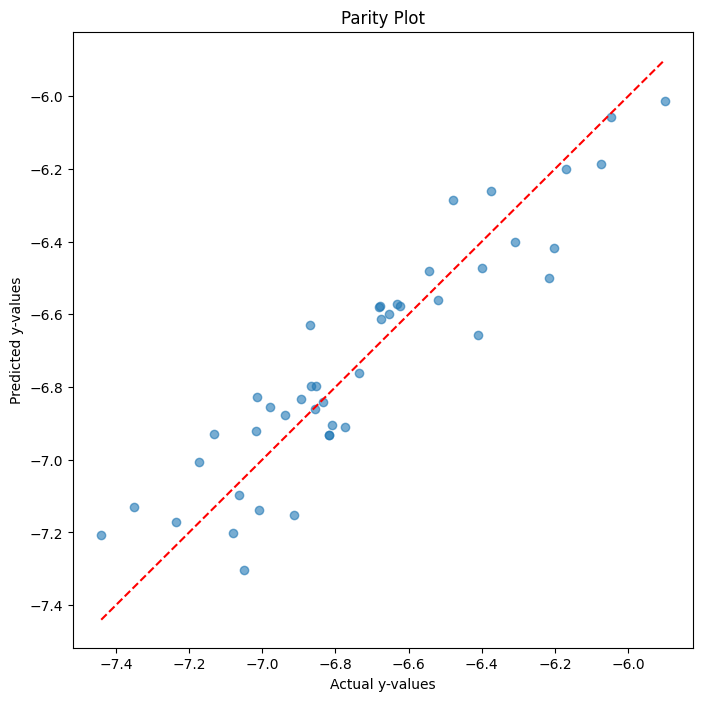

In [160]:
# Model, Loss, and Optimizer
model = FourMessagePassingLayer()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)


train_loader, test_loader = construct_dataloaders(index_test_graphs, batch_size=4, modified=True)

# Training Loop
epochs = 1000
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for graph in train_loader:
        optimizer.zero_grad()
        pred = model(graph)
        loss = loss_fn(pred, graph.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate and Collect Predictions for All Graphs
model.eval()
actual = []
predicted = []
with torch.no_grad():
    for loader in [train_loader, test_loader]:  # Process both train and test loaders
        for batch in loader:
            pred = model(batch)
            actual.extend(batch.y.cpu().numpy())
            predicted.extend(pred.cpu().numpy())

print(f"Collected actual energies: {len(actual)}")  # Should be 44

# Parity Plot
plt.figure(figsize=(8, 8))
plt.scatter(actual, predicted, alpha=0.6)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
plt.xlabel('Actual y-values')
plt.ylabel('Predicted y-values')
plt.title('Parity Plot')
plt.show()
